# **Sprint 14: Telecomunicaciones (Final project)**

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

**Objetivo:** identificar operadores ineficaces; para entregarle esta información a los supervisores de manera que ellos puedan tomar desiciones informadas en las medidas que decidan tomar respecto de los operadores con más bajo rendimiento.



**Clarificaciones:** 

- Consideraré operadores ineficacies al **10% peor en cada rubro**; es decir los que estén por encima del percentil 90 o debajo del Percentil 10 según sea el caso.

- Además quiero recalcar que durante el estudio **no voy a considerar a los trabajadores ineficaces como un grupo homogeneo**, sino que voy a encontrar cuales de los operadores están fallando en cada uno de los rubros, y los compararé con el resto del grupo.

- Sin embargo al final tendré 3 listas de ID's de operadores ineficientes una por cada rubro, las cuales uniré y eliminaré duplicados para tener **una única lista de operadores ineficaces**. 

Esto lo estoy haciendo porque al tratarlos por separado no sesgo los datos, soy más preciso al hacer las comparaciones, contrastando rubro por rubro. Además si los supervisores lo desean podrían revisar en qué están fallando los operadores, quizá no quieran simplemente despedirlos, sino ayudarlos a mejorar sus métricas. También es interesante ver cuales operadores aparecen en 2 o en las 3 listas; al final puedo tener una pivot table con los ID de los operadores ineficientes que indique en cuales rubros falla cada uno. Por todo lo anterior es que considero relevante tratarlo de esta manera.

## **Hipótesis:** 

1. "Los operadores considerados ineficaces tienen una tasa de llamadas perdidas (internas y externas) significativamente mayor que la media de los operadores eficaces."

2. "Los operadores ineficaces tienen un tiempo de espera en llamadas entrantes significativamente mayor que el de los operadores eficaces."

3. "Los operadores ineficaces realizan significativamente menos llamadas salientes que la media de los operadores eficientes"

## **Plan de acción** 

**1. Preprocesamiento de datos**
- Estudiar valores ausentes
- Estudiar el tipo de correspondencia
- Estudiar valores duplicados

**2. Análisis exploratorio de datos**

**3. Agrupar los datos por operator_id**

**4. Métodos para cada rubro:**
- Por la cantidad de llamadas perdidas (.count())
- Por los tiempos de espera en llamadas entrantes (.sum())
- Por la cantidad de llamadas salientes (.count())

**5. Encontrar los percentiles respectivos de cada rubro**
- P90 (Cuando mucho es ineficiente)
- P10 (Cuando poco es ineficiente)

**6. Separar a los operadores ineficientes y los eficientes de cada rubro**

**7. Comparar estadísticamente con una prueba estadística los grupos de cada rubro**

**8. Crear una pivot table con los usuarios ineficientes**

**9. Conclusiones**

# **Step 1: Data preprocessing**

## **Import libraries**

In [412]:
#!pip install pandas

In [413]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu
import math as mth
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import plotly.express as px


## **Read the data**

In [414]:
# Leo el archivo CSV que contiene la información de mi dataset
data = pd.read_csv('datasets/telecom_dataset_us.csv')

### **Data Exploration**

In [415]:
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
23633,167109,2019-09-10 00:00:00+03:00,in,False,907182.0,False,1,116,121
25668,167150,2019-09-10 00:00:00+03:00,out,False,905542.0,True,9,0,145
49658,168187,2019-11-28 00:00:00+03:00,out,True,937984.0,False,4,739,766
7615,166604,2019-11-20 00:00:00+03:00,in,False,893402.0,False,10,1484,1671
38488,167650,2019-11-23 00:00:00+03:00,in,False,921318.0,False,66,6647,7891
38982,167654,2019-11-21 00:00:00+03:00,in,False,918978.0,False,16,1848,2043
45998,168091,2019-11-13 00:00:00+03:00,out,False,958672.0,False,1,161,169
25135,167125,2019-09-26 00:00:00+03:00,out,False,902748.0,False,69,2245,3644
15051,166884,2019-08-30 00:00:00+03:00,out,False,895774.0,True,5,0,119
14338,166833,2019-11-27 00:00:00+03:00,out,False,903254.0,True,8,0,245


## **Duplicates and nulls**

In [416]:
#Busco duplicados y valores perdidos en el df data

def duplicates_and_nulls(df):
    if df.duplicated().sum() == 0:
        print('No se encontraron filas duplicadas en este dataframe.')
        
    else:
        print(f'---> Hay {df.duplicated().sum()} valores duplicados en este dataframe.')

    if df.isna().sum().sum() == 0:
        print('No se encontraron valores perdidos en este dataframe.')
    else:
        print(f"---> Hay {df.isna().sum().sum()} valores perdidos en las suguientes columnas:")
        print(data.isna().sum())

print('data')
duplicates_and_nulls(data)


data
---> Hay 4900 valores duplicados en este dataframe.
---> Hay 8289 valores perdidos en las suguientes columnas:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


**Tratar duplicados**

In [417]:
data[data.duplicated(keep=False)].head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
38,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
43,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
46,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473


Desconozco el origen de los valores duplicados, pero dejarlos sesgaría la información sobre el desempeño de los operadores; he decidido eliminarlos ya que es sencillo y así no afecten a la investigación, procedo a quitarlos del df.

In [418]:
data = data.drop_duplicates()

**Tratar valores perdidos**

In [419]:
data[data['operator_id'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


In [420]:
data[data['internal'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18


Todos los valores perdidos en operator_id dan un total de 7456, lo cual no representa una pérdida demasiado importante, además al no tener el operator_id es información irrelevante pues no sabríamos a quién pertenecen esas llamadas, así que tendremos que ignorarlos, por lo tanto las eliminaré del df. Por su parte los valores perdidos en internal, no afectan realmente para efectos de esta investigación debido a que trataremos por igual si es llamada interna o no, así que esos no necesito elimnarlos siempre y cuando el operator_id sí aparezca en el evento (fila), de cualquier manera son pocos los datos que se conservarán puesto que observo que hay algunos eventos que no tienen valores en ninguna de las dos variables (internal, operator_id).

In [421]:
# Elimino todos los eventos que no tienen valores en la columna operator_id
data = data.dropna(subset=['operator_id'])

## **Data Wrangling**

Voy a cambiar los tipos de las columnas que me parecen más adecuados.

In [422]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41546 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              41546 non-null  int64  
 1   date                 41546 non-null  object 
 2   direction            41546 non-null  object 
 3   internal             41491 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       41546 non-null  bool   
 6   calls_count          41546 non-null  int64  
 7   call_duration        41546 non-null  int64  
 8   total_call_duration  41546 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 2.9+ MB


**Cambios:**
- user_id y operator_id, deberían ser object, a pesar de ser números, en realidad son claves únicas, que nunca vamos a utilizar para hacer operaciones matemáticas; para evitar confusiones sería mejor cambiarlos.

- date debería ser un datetime.

- internal debería ser booleano.



In [423]:
# Verificar si hay algún valor con decimales distintos de .0
tiene_decimales_reales = any(data['operator_id'].dropna().apply(lambda x: x != float(int(x))))

if not tiene_decimales_reales:
    print("✅ Todos los valores terminan con .0 (no hay decimales reales)")
else:
    print("⚠️ Hay valores con decimales distintos de .0")

✅ Todos los valores terminan con .0 (no hay decimales reales)


In [424]:
# operator_id cambio a object
data['operator_id'] = data['operator_id'].astype(int)
data['operator_id'] = data['operator_id'].astype(str)

# user_id cambio a object
data['user_id'] = data['user_id'].astype(str)

# internal a bool
data['internal'] = data['internal'].astype(bool)

# date to datetime
data['date'] = pd.to_datetime(data['date']).dt.date


Cotejo que los cambios sean correctos

In [425]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Index: 41546 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              41546 non-null  object
 1   date                 41546 non-null  object
 2   direction            41546 non-null  object
 3   internal             41546 non-null  bool  
 4   operator_id          41546 non-null  object
 5   is_missed_call       41546 non-null  bool  
 6   calls_count          41546 non-null  int64 
 7   call_duration        41546 non-null  int64 
 8   total_call_duration  41546 non-null  int64 
dtypes: bool(2), int64(3), object(4)
memory usage: 2.6+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
5,166377,2019-08-05,out,False,880020,False,2,3,29
...,...,...,...,...,...,...,...,...,...
53895,168606,2019-11-09,out,False,957922,False,4,551,593
53896,168606,2019-11-10,out,True,957922,False,1,0,25
53897,168606,2019-11-10,out,True,957922,True,1,0,38
53898,168606,2019-11-11,out,True,957922,False,2,479,501


Ya realicé los cambios, sin embargo descubrí que la información que tenemos no es equitativa para cada mes, esto apunta a que el número de operadores ha ido aumentando con el paso de los meses por lo cual tendré que separar por meses la información y entregar reportes mensuales en vez de basarme en todo el histórico de inicidencias, tendré que mostrar en cada mes cuales fueron los operadores con peor rendimiento.

In [426]:
# Distribución de incidencias según la fecha
fig = px.histogram(
    data, x='date', title='Con el paso del tiempo hay más incidencias en el dataframe',
    labels={'date': 'Fecha'}
)

fig.update_layout(
    yaxis_title='Total de incidencias'
)

fig.show()

In [427]:
# Crear un DataFrame con el conteo de operadores únicos por fecha
operadores_por_fecha = data.groupby('date')['operator_id'].nunique().reset_index()
operadores_por_fecha.rename(columns={'operator_id': 'count_unique_operators'}, inplace=True)

# Crear la gráfica de líneas interactiva
fig = px.line(operadores_por_fecha, 
              x='date', 
              y='count_unique_operators',
              title='Se agregaron más de 400 nuevos operadores en 3 meses',
              labels={'date': 'Fecha', 'count_unique_operators': 'Total de Operadores'},
              markers=True,  # Mostrar marcadores en cada punto
              )

fig.update_traces(
    marker_color='orange'  # Color de los marcadores (verde)
)

fig.show()

In [461]:
operadores_por_fecha['date'] = pd.to_datetime(operadores_por_fecha['date'])
operadores_por_fecha['month'] = operadores_por_fecha['date'].dt.to_period('M')

In [463]:
operadores_por_fecha

,date,count_unique_operators,month
0,2019-08-02,3,2019-08
1,2019-08-03,2,2019-08
2,2019-08-04,2,2019-08
3,2019-08-05,4,2019-08
4,2019-08-06,7,2019-08
...,...,...,...
113,2019-11-24,115,2019-11
114,2019-11-25,426,2019-11
115,2019-11-26,408,2019-11
116,2019-11-27,432,2019-11


### **Divide by Months**

Para solucionar esto, voy a dividir por meses las incidencias, de manera que pueda tener información para cada mes, y pueda mostrar quiene son los operadores con peor rendimiento en cada mes.

In [428]:
# Creo una columna que indique el mes y año al que pertenece cada una de las inicidencias del df.
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.to_period('M')

In [429]:
# DF ya listo después de limpieza y transformación de datos.
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
1,166377,2019-08-05,out,True,880022,True,3,0,5,2019-08
2,166377,2019-08-05,out,True,880020,True,1,0,1,2019-08
3,166377,2019-08-05,out,True,880020,False,1,10,18,2019-08
4,166377,2019-08-05,out,False,880022,True,3,0,25,2019-08
5,166377,2019-08-05,out,False,880020,False,2,3,29,2019-08
...,...,...,...,...,...,...,...,...,...,...
53895,168606,2019-11-09,out,False,957922,False,4,551,593,2019-11
53896,168606,2019-11-10,out,True,957922,False,1,0,25,2019-11
53897,168606,2019-11-10,out,True,957922,True,1,0,38,2019-11
53898,168606,2019-11-11,out,True,957922,False,2,479,501,2019-11


**Este es el df que utilizaré para esta investigación**

# **Step 2: Group by**

Voy a crear nuevos df, uno por cada uno de los rubros que estamos investigando:

- Total de llamadas perdidas
- Tiempos espera en sus llamadas
- Total de llamadas salientes

 Para lograrlo voy a agrupar los datos por mes (cohort) y operador (operator_id) para posteriormente encontrar por mes a los operadores que tuvieron peores rendimientos.

## **Missed Calls**

In [430]:
# Llamadas perdidas.
missed_calls = data.groupby(['month', 'operator_id'])['is_missed_call'].count().reset_index()
missed_calls = missed_calls.rename(columns={'is_missed_call': 'count'})
missed_calls.info()
missed_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118 entries, 0 to 2117
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   month        2118 non-null   period[M]
 1   operator_id  2118 non-null   object   
 2   count        2118 non-null   int64    
dtypes: int64(1), object(1), period[M](1)
memory usage: 49.8+ KB


,month,operator_id,count
0,2019-08,879896,64
1,2019-08,879898,50
2,2019-08,880020,8
3,2019-08,880022,8
4,2019-08,880026,35


## **Total Hold Time**

In [431]:
# Total en de tiempos de espera de las llamadas entrantes (contestadas)

# Creo una columna con los tiempos de espera
data['hold'] = data['total_call_duration'] - data['call_duration']

# Filtro las llamadas que son entrantes y no son peridas
calls = data[(data['is_missed_call'] == False) & (data['direction'] == 'in')]

# Agrupo por operador y por mes
total_hold = calls.groupby(['operator_id', 'month',])['hold'].sum().reset_index()
total_hold = total_hold.rename(columns={'hold': 'total_hold'})
total_hold.info()
total_hold.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   operator_id  1456 non-null   object   
 1   month        1456 non-null   period[M]
 2   total_hold   1456 non-null   int64    
dtypes: int64(1), object(1), period[M](1)
memory usage: 34.3+ KB


,operator_id,month,total_hold
0,879896,2019-08,404
1,879896,2019-09,129
2,879896,2019-10,41
3,879898,2019-08,157
4,879898,2019-09,488
5,879898,2019-10,865
6,879898,2019-11,170
7,880020,2019-08,16
8,880020,2019-09,38
9,880022,2019-10,18


## **Total Out calls**

In [432]:
# Total de llamadas salientes

# Filtro el df para que se muestren solo las llamadas salientes
out_calls = data[data['direction'] == 'out']

# Agrupo contando por operador y mes
total_out_calls = out_calls.groupby(['operator_id', 'month'])['direction'].count().reset_index()
total_out_calls = total_out_calls.rename(columns={'direction': 'count'})
total_out_calls.info()
total_out_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   operator_id  1667 non-null   object   
 1   month        1667 non-null   period[M]
 2   count        1667 non-null   int64    
dtypes: int64(1), object(1), period[M](1)
memory usage: 39.2+ KB


,operator_id,month,count
0,879896,2019-08,51
1,879896,2019-09,28
2,879896,2019-10,13
3,879896,2019-11,4
4,879898,2019-08,40


**Estos 3 dataframes son los que me servirán para encontrar a los operadores con peores rendimientos.**

- missed_calls
- total_hold
- total_out_calls

# **Step 3: Analysis**

Utilizando percentiles en cada uno de los 3 rubros, voy a analizar filtrar los df para optener los ids de los operadores con más bajos rendimientos en el mes de noviembre 2019.

## **Llamadas Perdidas**

In [433]:
missed_09 = missed_calls[missed_calls['month'] == '2019-11']

# Calcular el percentil 90
p90 = np.percentile(missed_09['count'], 90)

print("Demasiadas llamadas perdidas:", p90)


Demasiadas llamadas perdidas: 59.0


**Prueba de hipótesis llamadas peridadas**

In [434]:
# Dividir los grupos
group_peor = missed_09['count'] >= p90  # Peor 10% (valores altos)
group_resto = missed_09['count'] < p90   # Resto 90%


**Hipótesis:**

H₀: No hay diferencia entre el grupo peor y el resto.

H₁: El grupo peor tiene valores significativamente más altos (peor rendimiento).

In [435]:
# Prueba Mann-Whitney U
stat, p_value = stats.mannwhitneyu(group_peor, group_resto)

print('"Total de llamadas perdidas" Comparación de grupos.')
print(f"Estadístico U: {stat}")
print(f"p-value: {p_value}")

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("✅ Rechazamos H₀: El grupo peor es significativamente peor (p < 0.05).")
else:
    print("❌ No hay evidencia para rechazar H₀ (p ≥ 0.05).")

"Total de llamadas perdidas" Comparación de grupos.
Estadístico U: 63342.0
p-value: 1.1504640865070765e-215
✅ Rechazamos H₀: El grupo peor es significativamente peor (p < 0.05).


In [436]:
operators_missed_09 = missed_09[missed_09['count'] >= 59]

In [437]:
operators_missed_09 = operators_missed_09.rename(columns={'count': 'missed_calls'})
operators_missed_09

,month,operator_id,missed_calls
1344,2019-11,882686,60
1350,2019-11,887276,79
1361,2019-11,889410,63
1362,2019-11,889754,60
1366,2019-11,890402,59
...,...,...,...
1866,2019-11,944646,66
1937,2019-11,948182,63
1962,2019-11,951508,75
1984,2019-11,952948,96


Estos son los operadores con peor rendimiento en llamadas perdias el mes de noviembre 2019

## **Tiempos de espera**

In [438]:
hold_09 = total_hold[total_hold['month'] == '2019-11']

# Calcular el percentil 90
p90 = np.percentile(hold_09['total_hold'], 90)

print("Demasiadas llamadas perdidas:", p90)

Demasiadas llamadas perdidas: 2492.5


In [439]:
# Dividir los grupos
group_peor = hold_09['total_hold'] >= p90  # Peor 10% (valores altos)
group_resto = hold_09['total_hold'] < p90   # Resto 90%


**Hipótesis:**

H₀: No hay diferencia entre el grupo peor y el resto.

H₁: El grupo peor tiene valores significativamente más altos (peor rendimiento).

In [440]:
# Prueba Mann-Whitney U
stat, p_value = stats.mannwhitneyu(group_peor, group_resto)

print('"Tiempos de espera" Comparación de grupos.')
print(f"Estadístico U: {stat}")
print(f"p-value: {p_value}")

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("✅ Rechazamos H₀: El grupo peor es significativamente peor (p < 0.05).")
else:
    print("❌ No hay evidencia para rechazar H₀ (p ≥ 0.05).")

"Tiempos de espera" Comparación de grupos.
Estadístico U: 31136.0
p-value: 4.2848490497286975e-156
✅ Rechazamos H₀: El grupo peor es significativamente peor (p < 0.05).


**Los grupos son diferentes**

In [441]:
operators_hold_09 = hold_09[hold_09['total_hold'] > 2492]
operators_hold_09.head()

,operator_id,month,total_hold
70,887276,2019-11,3752
147,891410,2019-11,3387
209,893402,2019-11,3720
212,893420,2019-11,2943
216,893804,2019-11,4533


En este df se encuentran los operadores que tuvieron mayores tiempos de espera en el mes de noviembre.

## **Total de llamadas salientes**

In [442]:
calls_09 = total_out_calls[total_out_calls['month'] == '2019-11']

# Calcular el percentil 10
p10 = np.percentile(calls_09['count'], 10)

print("Demasiadas llamadas perdidas:", p10)

Demasiadas llamadas perdidas: 1.0


In [443]:
# Dividir los grupos
group_peor = hold_09['total_hold'] >= p10  # Peor 10% (valores altos)
group_resto = hold_09['total_hold'] < p10   # Resto 90%

In [444]:
# Prueba Mann-Whitney U
stat, p_value = stats.mannwhitneyu(group_peor, group_resto)

print('"Total de llamadas salientes" Comparación de grupos.')
print(f"Estadístico U: {stat}")
print(f"p-value: {p_value}")

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("✅ Rechazamos H₀: El grupo peor es significativamente peor (p < 0.05).")
else:
    print("❌ No hay evidencia para rechazar H₀ (p ≥ 0.05).")

"Total de llamadas salientes" Comparación de grupos.
Estadístico U: 309136.0
p-value: 1.3479398465125675e-243
✅ Rechazamos H₀: El grupo peor es significativamente peor (p < 0.05).


In [445]:
operators_calls_09 = calls_09[calls_09['count'] < 2 ]
operators_calls_09

,operator_id,month,count
91,888406,2019-11,1
108,888540,2019-11,1
128,890232,2019-11,1
225,891946,2019-11,1
306,896010,2019-11,1
...,...,...,...
1648,969288,2019-11,1
1650,969380,2019-11,1
1653,970240,2019-11,1
1656,970250,2019-11,1


En este df se encuentran los operadores con peor rendimiento en llamadas salientes.

# **Step 4: Results**

Ya hemos demostrado que los grupos con los operadores ineficaces tienen significativamente peores resultados que el resto de los operadores; ahora es tiempo de agrupar la información de los df.

In [446]:
# Crear una columna indicadora en cada DataFrame

# Asignación segura con .loc
operators_missed_09.loc[:, 'in_missed'] = 1  # Sintaxis: .loc[filas, columna]
operators_hold_09.loc[:, 'in_hold'] = 1
operators_calls_09.loc[:, 'in_calls'] = 1

/var/folders/g8/hw38fjcn7q581f61hm__1x0h0000gn/T/ipykernel_1158/595098674.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/g8/hw38fjcn7q581f61hm__1x0h0000gn/T/ipykernel_1158/595098674.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [447]:
# Unir todos los DataFrames en uno solo (outer join para incluir todos los IDs)
merged_df = pd.merge(
    pd.merge(
        operators_missed_09[['operator_id', 'in_missed']],
        operators_hold_09[['operator_id', 'in_hold']],
        on='operator_id',
        how='outer'
    ),
    operators_calls_09[['operator_id', 'in_calls']],
    on='operator_id',
    how='outer'
)

# Rellenar NaN con 0 (si no aparecen en un DataFrame)
merged_df = merged_df.fillna(0)

In [448]:
# Cambio los tipos de las columnas a int

list = ['in_missed', 'in_hold', 'in_calls']
for column in list:
    merged_df[column] = merged_df[column].astype(int)

## **Tabla de operadores ineficaces**

In [467]:
operadores_ineficaces = merged_df
operadores_ineficaces

,operator_id,in_missed,in_hold,in_calls
0,882686,1,0,0
1,887276,1,1,0
2,888406,0,0,1
3,888540,0,0,1
4,889410,1,0,0
...,...,...,...,...
166,969288,0,0,1
167,969380,0,0,1
168,970240,0,0,1
169,970250,0,0,1


**En esta tabla se encuentran los operadores con bajo desempeño en cada uno de los 3 rubros (Demasiadas llamadas perdidas, Demasiado tiempo de espera, pocas llamadas realizadas).**

In [450]:
corr = merged_df[['in_missed', 'in_hold', 'in_calls']].corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu',
    title='Parece haber una correlación negativa entre las llamadas salientes y las otras dos métricas',
    width=600,
    height=450,
)
fig.show()

Esto me hace pensar que tal vez una buena cantidad de los operadores que están haciendo pocas llamadas salientes, no son malos empleados, sólo no lo están priorizando como parte de sus labores, porque están más concentrados en no perder llamadas y en tener tiempos de espera bajos; además vale la pena recalcar que en general la mayoría de los operadores no tiene muchas llamadas salientes.

In [451]:
# Calcular el total de operadores por rubro (suma de 1s)
summary = merged_df[['in_missed', 'in_hold', 'in_calls']].sum().reset_index()
summary.columns = ['Rubro', 'Total_Operadores']

# Gráfico de barras
fig = px.bar(
    summary,
    x='Rubro',
    y='Total_Operadores',
    color='Rubro',
    text='Total_Operadores',
    title='Total de operadores ineficientes por Rubro',
    labels={'Rubro': 'Métrica', 'Total_Operadores': 'Número de Operadores'},
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1']
)

# Ajustar diseño
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title="Métrica",
    yaxis_title="Total de Operadores",
    showlegend=False
)
fig.show()

La mayoría de nuestros operadores está fallando en contestar llamadas.

## **Operadores ineficaces en más de una métrica**

In [452]:
# Unir los tres DataFrames y filtrar los operator_id comunes
common_operators = pd.merge(
    pd.merge(
        operators_missed_09[['operator_id']],
        operators_hold_09[['operator_id']],
        on='operator_id',
        how='inner'
    ),
    operators_calls_09[['operator_id']],
    on='operator_id',
    how='inner'
)

In [453]:
if common_operators['operator_id'].unique().size >= 1:
    print(f"Operadores comunes en los 3 DataFrames: {common_operators}")
else:
    print('No existe ningún operador que sea ineficaz en los 3 rubros.')

No existe ningún operador que sea ineficaz en los 3 rubros.


Después de haber revisado la tabla de operadores ineficaces puedo observar que ninguno de ellos se encuentra en los 3 grupos.

In [454]:
missed_and_hold = pd.merge(operators_missed_09['operator_id'],
        operators_hold_09['operator_id'],
        on='operator_id',
        how='inner')

missed_and_hold.size

32

In [455]:
missed_and_calls = pd.merge(operators_missed_09[['operator_id']],
                            operators_calls_09[['operator_id']],
                            on='operator_id',
                            how='inner')
missed_and_calls.size

0

In [456]:
calls_and_hold = pd.merge(operators_calls_09['operator_id'],
                          operators_hold_09['operator_id'],
                          on='operator_id',
                          how= 'inner')
calls_and_hold.size

0

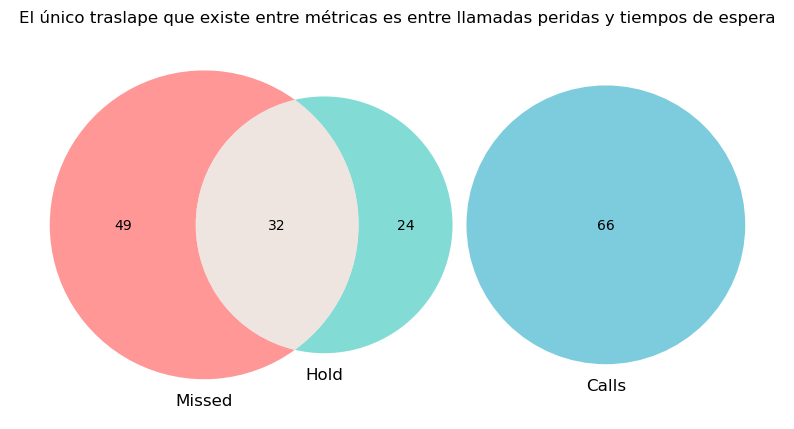

In [457]:
# Crear conjuntos de operadores por métrica
set_missed = set(merged_df[merged_df['in_missed'] == 1]['operator_id'])
set_hold = set(merged_df[merged_df['in_hold'] == 1]['operator_id'])
set_calls = set(merged_df[merged_df['in_calls'] == 1]['operator_id'])

# Diagrama de Venn
plt.figure(figsize=(10, 8))
venn3(
    [set_missed, set_hold, set_calls],
    set_labels=('Missed', 'Hold', 'Calls'),
    set_colors=('#FF6B6B', '#4ECDC4', '#45B7D1'),  # Colores personalizados
    alpha=0.7
)
plt.title('El único traslape que existe entre métricas es entre llamadas peridas y tiempos de espera')
plt.show()

Tan solo 32 operadores son al mismo tiempo ineficaces en llamadas peridas y tiempos largos de espera.

## **Conclusiones**

En este análisis pude encontrar a los operadores que tiene peores rendimientos respecto de sus demás compañeros, en cada una de las métricas encontré al 10 % con peores resultados. Posteriormente demostré con pruebas estadísticas que evidentemente los operadores con peor rendimiento son significativamente diferentes que el resto del grupo.

Por último intenté contrar a los operadores que estuvieran fallando en las 3 métricas, sin embargo para mi sorpresa no hubo ningún operador que falle en las 3, mi conjetura es que en general los operadores que fallan teniendo pocas llamdas salientes, es porque están bastante ocupados contestando llamadas entrantes, y además suelen tener menores tiempos de espera.

Los supervisores pueden encontrar en las tablas, los id's de los operadores con los más bajos rendimientos, para tomar las decisiones que les competa.